# Lab-8: Convolutions and CNN

In this lab, you will practice simple deep learning model in Pytorch.


## Objectives:

1. Convolutions - application examples:
    - edge detection    
    - negation
    - blurring
    - sharpening
2. Building CNN in PyTorch
    - example CNN
    - comparing with Fully-connected NN

### Recap

1. What is the use of convolutions? (In general) <span style="color:blue"> Image and signal processing, computer vision, probability theory, etc.
2. Why use convolutional layers instead of fully-connected ones? <span style="color:blue"> **Weight Sharing**: Convolutional layers have less weights and therefore use less memory and run faster.  In fact, a fully connected layer is the same as a convolutional layer with a kernel size equal to the dimensions of the image. That’s a huge window (by orders of magnitude) compared to the typical 3x3xN kernel size used in typical convolutional neural networks. **Location Invariance**: Let’s say you want to classify whether or not there’s an elephant in an image. Because you are sliding your filters over the whole image you don’t really care where the elephant occurs. In practice, pooling also gives you invariance to translation, rotation and scaling. **Compositionality**: Each filter composes a local patch of lower-level features into higher-level representation. That’s why CNNs are so powerful in Computer Vision. It makes intuitive sense that you build edges from pixels, shapes from edges, and more complex objects from shapes.
Must read section 9.2 in: https://www.deeplearningbook.org/contents/convnets.html


## Convolutions
Let's upload some image (you can try your own image changing the url)

In [3]:
import urllib.request
url = "https://res-2.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_256,w_256,f_auto,q_auto:eco/lss423kothpqpjpwbzg0"
filename = 'grid_img.jpg'
urllib.request.urlretrieve(url, filename)

('grid_img.jpg', <http.client.HTTPMessage at 0x12f36dc18>)

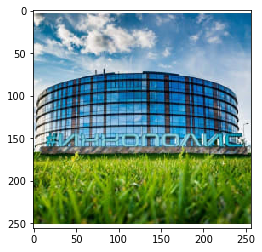

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy import ndimage

# Let's read and plot the image
image = plt.imread('grid_img.jpg')
plt.imshow(image)

original img shape:  (256, 256, 3)
grayscale img shape (256, 256)


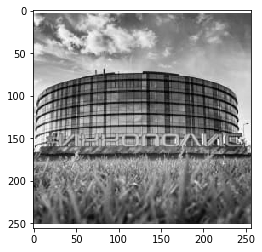

In [5]:
gray_image = rgb2gray(image)
plt.imshow(gray_image * 100, cmap='gray')
print("original img shape: ", image.shape)
print("grayscale img shape", gray_image.shape)

[[ 1  1  1]
 [ 0  0  0]
 [-1 -1 -1]] is a kernel for detecting horizontal edges
[[-1  0  1]
 [-1  0  1]
 [-1  0  1]] is a kernel for detecting vertical edges


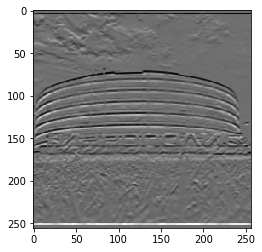

In [7]:
# first, let's define edge-detecting filters
horizontal_kernel = np.array([[1, 1, 1], 
                              [0, 0, 0], 
                              [-1, -1, -1]])
print(horizontal_kernel, 'is a kernel for detecting horizontal edges')
 
vertical_kernel = np.array([[-1, 0, 1], 
                            [-1, 0, 1], 
                            [-1, 0, 1]])
print(vertical_kernel, 'is a kernel for detecting vertical edges')

# out_h = ndimage.convolve(gray_image, horizontal_kernel, mode='reflect')
# out_v = ndimage.convolve(gray_image, vertical_kernel, mode='reflect')

Let's apply different types of convolutions on this image. Complete the following function.

Take care of dimensions - the resuting image should be of the same size.
Hint:

![alt text](https://i.gyazo.com/5265866b07235dfa181de39913e94713.png)

Horizontal kernel applied


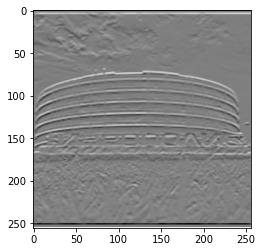

In [5]:
# apply kernel on input image such that the image size is preserved
def convolve(img, kernel):
        w, h = img.shape[0], img.shape[1]
        f = kernel.shape[0]
        if (f - 1) % 2 !=0 :
            print("failure to choose apt padding, choose another filter size!")
        padding = (f - 1)//2
        padded_img = np.lib.pad(img, ((padding, padding), (padding, padding)), 'constant', constant_values = ((0,0),(0,0)))
        result = np.zeros(img.shape)
        for i in range(h):
            for j in range(w):
                # we chose padding size such that when sliding through the padded image
                # with the kernel we obtain exactly same dimensionality (w x h)
                result[i,j] = np.sum(padded_img[i:i + f, j:j+f] * kernel)                 
        return result

c = convolve(gray_image, horizontal_kernel)
print("Horizontal kernel applied")
plt.imshow(c, cmap='gray')

Vertical kernel applied


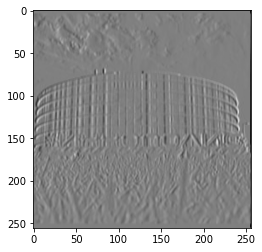

In [6]:
c = convolve(gray_image, vertical_kernel)
print("Vertical kernel applied")
plt.imshow(c, cmap='gray')

Your kernel applied


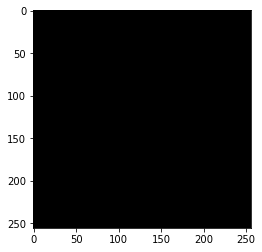

In [7]:
# play with numbers, see how changing the kernel affects the result
your_kernel = np.array([[0, 0, 0], 
                        [0, 0, 0], 
                        [0, 0, 0]])

c = convolve(gray_image, your_kernel)
print("Your kernel applied")
plt.imshow(c, cmap='gray')

some_kernel = np.array([[-1]])

Negative kernel applied


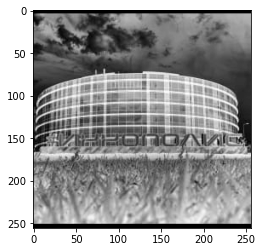

In [9]:
# Define the kernel that will result in reversed image, in which the lightest areas of
# the photographed subject appear darkest and the darkest areas appear the lightest.
negative_kernel = np.array([[-1]])

c = convolve(gray_image, negative_kernel)
print("Negative kernel applied")
plt.imshow(c, cmap='gray')

Blur kernel applied


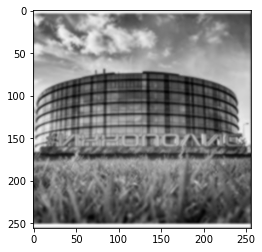

In [10]:
# Define the kernel that will result in a blurred image
# How can we control the degree of blur?
v1 = 0.5
v = 0.1
# this is an example of ~ gaussian blur
blur_kernel = np.array([[v, v, v, v, v], 
                        [v, v1, v1, v1, v],
                        [v, v1, 2, v1, v],
                        [v, v1, v1, v1, v],
                        [v, v, v, v, v]])

#simple sum
blur_kernel2 = np.ones((11,11))

c_blurred = convolve(gray_image, blur_kernel)
print("Blur kernel applied")
plt.imshow(c_blurred, cmap='gray')

Sharpen kernel applied


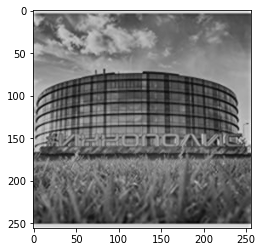

In [11]:
# Now let's sharpen the blurred image back 
sharpen_kernel = np.array([[0, -1, 0], 
                           [-1, 5, -1], 
                           [0, -1, 0]])

c = convolve(c_blurred, sharpen_kernel)
print("Sharpen kernel applied")
plt.imshow(c, cmap='gray')

## CNN with PyTorch

### 1. Data Loading

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch. utils.data import DataLoader

batch_size = 32
test_batch_size = 100

# Transformations
data_transformations = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

# Data Source
mnist_train = datasets.MNIST('../data', train=True, download=True,
                       transform=data_transformations)
mnist_test = datasets.MNIST('../data', train=False,
                            transform=data_transformations)


# Data loaders
train_loader = DataLoader(mnist_train,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=test_batch_size, shuffle=True)

## 2.1 CNN model

In [13]:
class Net(nn.Module):
    # Convolution formula: ((n + 2p - f) / s) + 1
        
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Exercise: calclulate shape after each layer
        # print("1", x.shape)
        # initial shape: [32, 1, 28, 28]
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # print("2", x.shape) 
        # [32, 10, 24, 24] -> [32, 10, 12, 12]
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # print("3", x.shape) 
        # [32, 20, 8, 8] -> [32, 20, 4, 4]
        x = x.view(-1, 320)
        # print("4", x.shape) 
        # [32, 320]
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_cnn = Net().to(device)

## 2.2 Fully-conected model from the last class

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         self.fc1 = nn.Linear(28*28, 500)
#         self.fc2 = nn.Linear(500, 250)
#         self.fc3 = nn.Linear(250, 100)
#         self.fc4 = nn.Linear(100, 10)
        # reducing number of params to match that of CNN
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 100)
        self.fc3 = nn.Linear(100, 40)
        self.fc4 = nn.Linear(40, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))        
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_nn = Net().to(device)

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
# Let's compare the number of parameters of these models:
print("Number of params in the Fully-connected model:", count_parameters(model_nn))
print("Number of params in the CNN model:", count_parameters(model_cnn))
      

Number of params in the Fully-connected model: 22250
Number of params in the CNN model: 21840


Task: Try changing the fully-connected model to have the same number of parameters as CNN and compare the resulting performance 

## 3. Training and testing

In [17]:
def train( model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            
def test( model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [18]:
epochs = 10
lr = 0.01
momentum = 0.5
log_interval = 700

# training CNN model
model = model_cnn
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

torch.save(model.state_dict(), "mnist_cnn.pt")

C:\Users\a.khusainova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.336505
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.410739
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.253238

Test set: Average loss: 0.1122, Accuracy: 9636/10000 (96.36%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.191319
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.739941
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.378859

Test set: Average loss: 0.0767, Accuracy: 9759/10000 (97.59%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.439407
Train Epoch: 3 [22400/60000 (37%)]	Loss: 0.056283
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.414771

Test set: Average loss: 0.0655, Accuracy: 9799/10000 (97.99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.114824
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.226501
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.284257

Test set: Average loss: 0.0568, Accuracy: 9830/10000 (98.30%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.047274
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.123469
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.296363

Test set: Average 

In [19]:
# training the fully-connected model

model = model_nn
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

torch.save(model.state_dict(), "mnist_nn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317126
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.153769
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.345231

Test set: Average loss: 0.2539, Accuracy: 9209/10000 (92.09%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.217480
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.144109
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.137246

Test set: Average loss: 0.1784, Accuracy: 9446/10000 (94.46%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.308335
Train Epoch: 3 [22400/60000 (37%)]	Loss: 0.183196
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.111514

Test set: Average loss: 0.1443, Accuracy: 9542/10000 (95.42%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.077133
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.268527
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.101822

Test set: Average loss: 0.1410, Accuracy: 9547/10000 (95.47%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.032642
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.068806
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.186894

Test set: Average 